# Case study: re-analysis of zebrafish (*Danio rerio*) embryogenesis single-cell data

This notebook will demonstrate scRNA-seq processing with `orthomap` using zebrafish scRNA data from ([Farrell et al., 2018](https://doi.org/10.1126/science.aar3131); [Wagner et al., 2018](https://doi.org/10.1126/science.aar4362); [Qiu et al., 2022](https://doi.org/10.1038/s41588-022-01018-x)).

scRNA data were obtained from http://tome.gs.washington.edu/, converted into Scanpy `AnnData` objects ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)) and are availabe here:

https://doi.org/10.5281/zenodo.7243602

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.qiu22_zebrafish(datapath='data')` (download folder set to `'data'`).

## Notebook file

Notebook file can be obtained here:

[https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/zebrafish_example.ipynb](https://raw.githubusercontent.com/kullrich/orthomap/main/docs/notebooks/zebrafish_example.ipynb)

## Steps

To process the scRNA data, we will do the following:

0. Run OrthoFinder to obtain orthogroups
1. Get query species taxonomic lineage information
2. Get query species orthomap
3. Map OrthoFinder gene names and scRNA gene/transcript names
4. Get TEI values and add them to scRNA dataset
5. Get partial TEI values to visualize gene age class contributions
6. Process scRNA data and visualize TEI

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
# increase dpi
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Import orthomap python package submodules

In [2]:
# import submodules
from orthomap import qlin, gtf2t2g, of2orthomap, orthomap2tei, datasets

## Step 0 - run OrthoFinder to obtain orthogroups

`orthomap` can extract gene age classification from existing OrthoFinder results and link them with scRNA data.

A detailed how-to is available here:

https://orthomap.readthedocs.io/en/latest/tutorials/orthofinder.html

However, any pre-calculated gene age classification can be imported as a table using the function `orthomap2tei.read_orthomap(orthomapfile=filename)`.

The pre-calculated gene age classification file should be <tab> delimited with two columns `GeneID<tab>Phylostratum`, like e.g.:
    
```
GeneID<tab>Phylostratum
WBGene00000001<tab>1
WBGene00000002<tab>1
WBGene00000003<tab>1
WBGene00000004<tab>1
WBGene00000005<tab>2
```

OrthoFinder ([Emms and Kelly, 2019](https://doi.org/10.1186/s13059-019-1832-y)) results (-S last) using translated, longest-isoform coding sequences (CDS) from [Ensembl release-110](https://ftp.ensembl.org/pub/release-110/), including species taxonomic IDs, are available here: 

https://doi.org/10.5281/zenodo.7242264

or can be accessed with the `dataset` submodule of `orthomap`

`datasets.ensembl110_last(datapath='data')` (download folder set to `'data'`).

In [3]:
datasets.ensembl110_last(datapath='data')

100% [..............................................................................] 11317 / 11317

['data/ensembl_110_orthofinder_last_Orthogroups.GeneCount.tsv.zip',
 'data/ensembl_110_orthofinder_last_Orthogroups.tsv.zip',
 'data/ensembl_110_orthofinder_last_species_list.tsv']

## Step 1 - get query species taxonomic lineage information

Given a species name or taxonomic ID, the query species lineage information is extracted with the help of the `ete3` python toolkit and the `NCBI taxonomy` ([Huerta-Cepas et al., 2016](https://doi.org/10.1093/molbev/msw046)). This information is needed alongside with the taxonomic classifications for all species used in the OrthoFinder comparison.

The `orthomap` submodule `qlin` helps to get this information for you with the `qlin.get_qlin()` function as follows:

In [4]:
# get query species taxonomic lineage information
query_lineage = qlin.get_qlin(q='Danio rerio')

query name: Danio rerio
query taxID: 7955
query kingdom: Eukaryota
query lineage names: 
['root(1)', 'cellular organisms(131567)', 'Eukaryota(2759)', 'Opisthokonta(33154)', 'Metazoa(33208)', 'Eumetazoa(6072)', 'Bilateria(33213)', 'Deuterostomia(33511)', 'Chordata(7711)', 'Craniata(89593)', 'Vertebrata(7742)', 'Gnathostomata(7776)', 'Teleostomi(117570)', 'Euteleostomi(117571)', 'Actinopterygii(7898)', 'Actinopteri(186623)', 'Neopterygii(41665)', 'Teleostei(32443)', 'Osteoglossocephalai(1489341)', 'Clupeocephala(186625)', 'Otomorpha(186634)', 'Ostariophysi(32519)', 'Otophysi(186626)', 'Cypriniphysae(186627)', 'Cypriniformes(7952)', 'Cyprinoidei(30727)', 'Danionidae(2743709)', 'Danioninae(2743711)', 'Danio(7954)', 'Danio rerio(7955)']
query lineage: 
[1, 131567, 2759, 33154, 33208, 6072, 33213, 33511, 7711, 89593, 7742, 7776, 117570, 117571, 7898, 186623, 41665, 32443, 1489341, 186625, 186634, 32519, 186626, 186627, 7952, 30727, 2743709, 2743711, 7954, 7955]


## Step 2 - gene age class assignment (query species orthomap)

Here, `orthomap` use the query species information and OrthoFinder results to extract the oldest common tree node per orthogroup along a species tree and to assign this node as the gene age to the corresponding genes.

In a pairwise manner, the query species and any other species in the OrthoFinder result might share multiple tree nodes down to the root of the species tree, but have only one youngest tree node in common. Among all possible comparison between the query species and the other species, the oldest as defined by the species tree root is seected and used for the gene age assignment.

Given the `query species sequence name` (`seqname=`) used in the OrthoFinder comparison, the `query species taxonomic ID`(`qt=`), the `taxonomic IDs of all species` (`sl=`) used in the OrthoFinder comparison, the `orthogroup gene count` (`oc=`) results and the `orthogroups` (`og=`), an orthomap is constructed.

__Note:__ This step can take up to five minutes, depending on your hardware.

For this step to get the query species orthomap, one uses the `of2orthomap.get_orthomap()` function, like:

corresponds to main figure Figure 1B

In [5]:
# get query species orthomap

# download orthofinder results here: https://doi.org/10.5281/zenodo.7242264
# or download with datasets.ensembl110_last('data')
query_orthomap, orthofinder_species_list, of_species_abundance = of2orthomap.get_orthomap(
    seqname='7955.danio_rerio.pep',
    qt='7955',
    sl='data/ensembl_110_orthofinder_last_species_list.tsv',
    oc='data/ensembl_110_orthofinder_last_Orthogroups.GeneCount.tsv.zip',
    og='data/ensembl_110_orthofinder_last_Orthogroups.tsv.zip',
    continuity=True)
query_orthomap

7955.danio_rerio.pep
Danio rerio
7955
                                    species  taxID  \
0                 10020.dipodomys_ordii.pep  10020   
1    10029.cricetulus_griseus_chok1gshd.pep  10029   
2       10029.cricetulus_griseus_crigri.pep  10029   
3         10029.cricetulus_griseus_picr.pep  10029   
4            10036.mesocricetus_auratus.pep  10036   
..                                      ...    ...   
313          9986.oryctolagus_cuniculus.pep   9986   
314        99883.tetraodon_nigroviridis.pep  99883   
315        9994.marmota_marmota_marmota.pep   9994   
316            9999.urocitellus_parryii.pep   9999   
317    Xtropicalisv9.0.Named.primaryTrs.pep   8364   

                                               lineage  youngest_common  \
0    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           117571   
1    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           117571   
2    [1, 131567, 2759, 33154, 33208, 6072, 33213, 3...           117571   
3    [1, 1315

seqID Orthogroup  PSnum PStaxID         PSname  \
0      ENSDART00000013359.10  OG0000000      6   33213      Bilateria   
1       ENSDART00000136092.3  OG0000001      6   33213      Bilateria   
2       ENSDART00000148349.3  OG0000001      6   33213      Bilateria   
3       ENSDART00000160249.2  OG0000001      6   33213      Bilateria   
4       ENSDART00000174091.2  OG0000001      6   33213      Bilateria   
...                      ...        ...    ...     ...            ...   
24952   ENSDART00000125904.3  OG0035492     19  186625  Clupeocephala   
24953   ENSDART00000191935.1  OG0035493     25   30727    Cyprinoidei   
24954   ENSDART00000143229.2  OG0035494     29    7955    Danio rerio   
24955   ENSDART00000143837.3  OG0035494     29    7955    Danio rerio   
24956   ENSDART00000143384.2  OG0035495     22  186626       Otophysi   

       PScontinuity  
0          0.846154  
1          1.000000  
2          1.000000  
3          1.000000  
4          1.000000  
...             ...  
24952      0.400000  
24953      1.000000  
24954      1.000000  
24955      1.000000  
24956      0.666667  

[24957 rows x 6 columns]

### Gene age assignments per query species lineage node

Given an orthomap, one can get an overview of the gene age assignments per query species lineage node.

The `orthomap` submodule `of2orhomap` and the `of2orthomap.get_counts_per_ps()` function will show the distribution of the gene age classes and can be further visualized as follows:

In [6]:
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

PSnum  counts  PStaxID               PSname
PSnum                                             
3          3    4376    33154         Opisthokonta
6          6   10530    33213            Bilateria
8          8    2390     7711             Chordata
10        10    2838     7742           Vertebrata
11        11    1515     7776        Gnathostomata
13        13     760   117571         Euteleostomi
14        14     235     7898       Actinopterygii
16        16     275    41665          Neopterygii
18        18     231  1489341  Osteoglossocephalai
19        19     506   186625        Clupeocephala
20        20      33   186634            Otomorpha
22        22     120   186626             Otophysi
25        25     317    30727          Cyprinoidei
29        29     831     7955          Danio rerio

### Visualize number of species along query lineage and counts per gene age class

<AxesSubplot: >

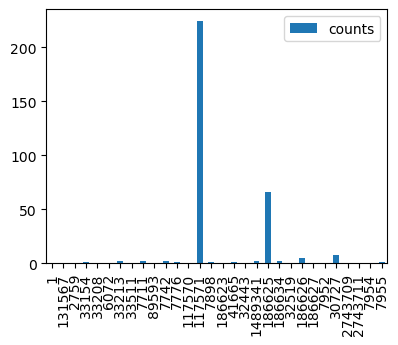

In [7]:
# show number of species along query lineage
of_species_abundance

# bar plot number of species along query lineage
of_species_abundance.plot.bar(y='counts', use_index=True)

corresponds to main figure Figure 1C

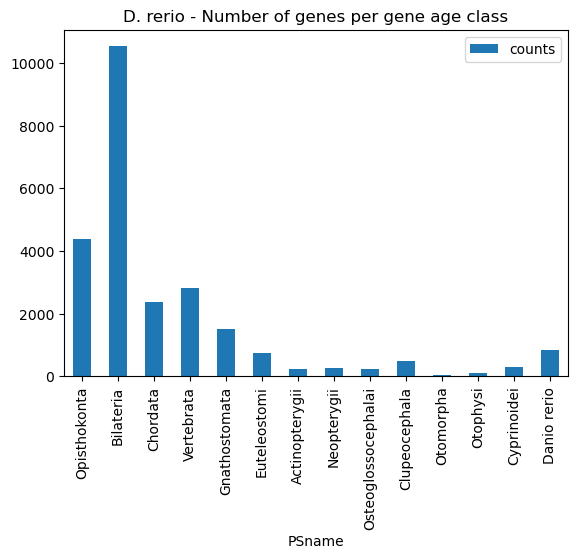

In [8]:
plt.rcParams['figure.figsize'] = [6.5, 4.5]
# show count per taxonomic group (PStaxID)
of2orthomap.get_counts_per_ps(query_orthomap)

# bar plot count per taxonomic group (PSname)
ax = of2orthomap.get_counts_per_ps(query_orthomap).plot.bar(y='counts', x='PSname')
ax.set_title('D. rerio - Number of genes per gene age class')
plt.show()
plt.rcParams['figure.figsize'] = [4.4, 3.3]

## Step 3 - map OrthoFinder gene names and scRNA gene/transcript names

To be able to link gene ages assignments from an orthomap and gene or transcript of scRNA dataset, one needs to check the overlap of the annotated gene names. With the `gtf2t2g` submodule of `orthomap` and the `gtf2t2g.parse_gtf()` function, one can extract gene and transcript names from a given gene feature file (`GTF`).

In [9]:
datasets.zebrafish_ensembl110_gtf('data')

100% [........................................................................] 18055420 / 18055420

'data/Danio_rerio.GRCz11.110.gtf.gz'

In [10]:
# get gene to transcript table for Danio rerio

# download zebrafish GTF file here:
# https://ftp.ensembl.org/pub/release-110/gtf/danio_rerio/Danio_rerio.GRCz11.110.gtf.gz
# or download with datasets.zebrafish_ensembl110_gtf('data')
query_species_t2g = gtf2t2g.parse_gtf(
    gtf='data/Danio_rerio.GRCz11.110.gtf.gz',
    g=True, b=True, p=True, v=True, s=True, q=True)

32520 gene_id found
59876 transcript_id found
59876 protein_id found
0 duplicated


In [11]:
query_species_t2g

gene_id       gene_id_version       transcript_id  \
0      ENSDARG00000000001  ENSDARG00000000001.6  ENSDART00000000004   
1      ENSDARG00000000002  ENSDARG00000000002.8  ENSDART00000000005   
2      ENSDARG00000000018  ENSDARG00000000018.9  ENSDART00000181044   
3      ENSDARG00000000018  ENSDARG00000000018.9  ENSDART00000138183   
4      ENSDARG00000000019  ENSDARG00000000019.9  ENSDART00000124452   
...                   ...                   ...                 ...   
59871  ENSDARG00000117825  ENSDARG00000117825.1  ENSDART00000194739   
59872  ENSDARG00000117826  ENSDARG00000117826.1  ENSDART00000194042   
59873  ENSDARG00000117826  ENSDARG00000117826.1  ENSDART00000194514   
59874  ENSDARG00000117827  ENSDARG00000117827.1  ENSDART00000194378   
59875  ENSDARG00000117827  ENSDARG00000117827.1  ENSDART00000194710   

      transcript_id_version gene_name       gene_type          protein_id  \
0      ENSDART00000000004.5   slc35a5  protein_coding  ENSDARP00000000004   
1      ENSDART00000000005.7    ccdc80  protein_coding  ENSDARP00000000005   
2      ENSDART00000181044.1      nrf1  protein_coding  ENSDARP00000149440   
3      ENSDART00000138183.2      nrf1  protein_coding  ENSDARP00000116798   
4      ENSDART00000124452.3     ube2h  protein_coding  ENSDARP00000107407   
...                     ...       ...             ...                 ...   
59871  ENSDART00000194739.1      None         lincRNA                None   
59872  ENSDART00000194042.1      None         lincRNA                None   
59873  ENSDART00000194514.1      None         lincRNA                None   
59874  ENSDART00000194378.1      None         lincRNA                None   
59875  ENSDART00000194710.1      None         lincRNA                None   

         protein_id_version  
0      ENSDARP00000000004.2  
1      ENSDARP00000000005.6  
2      ENSDARP00000149440.1  
3      ENSDARP00000116798.1  
4      ENSDARP00000107407.2  
...                     ...  
59871                  None  
59872                  None  
59873                  None  
59874                  None  
59875                  None  

[59876 rows x 8 columns]

### Import now, the scRNA dataset of the query species

Here, data is used, like in the publication ([Farrell et al., 2018](https://doi.org/10.1126/science.aar3131); [Wagner et al., 2018](https://doi.org/10.1126/science.aar4362); [Qiu et al., 2022](https://doi.org/10.1038/s41588-022-01018-x)).

scRNA data was downloaded from http://tome.gs.washington.edu/ as R rds files, combined into a single Seurat object and converted into loom and AnnData (h5ad) files to be able to analyse with e.g. python scanpy or orthomap package and is available here:

https://doi.org/10.5281/zenodo.7243602

or can be accessed with the `dataset` submodule of `orthomap`:

`datasets.qiu22_zebrafish(datapath='data')` (download folder set to `'data'`).

In [12]:
# load scRNA data

# download zebrafish scRNA data here: https://doi.org/10.5281/zenodo.7243602
# or download with datasets.qui22_zebrafish(datapath='data')

#zebrafish_data = datasets.qiu22_zebrafish(datapath='data')
zebrafish_data = sc.read('data/zebrafish_data.h5ad')

### Get an overview of observations

In [13]:
zebrafish_data

AnnData object with n_obs × n_vars = 71203 × 20418
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'group', 'cell_state', 'cell_type'
    var: 'features', 'genes'

In [14]:
zebrafish_data.obs

orig.ident  nCount_RNA  nFeature_RNA  \
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC     ZFHIGH      5773.0          2570   
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT     ZFHIGH      2312.0          1451   
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC     ZFHIGH      4180.0          2166   
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN     ZFHIGH      6686.0          2845   
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT     ZFHIGH     20095.0          4993   
...                                      ...         ...           ...   
hpf24_DEW057_TGACACAACAG_GCCACATC     DEW057      3916.0          1328   
hpf24_DEW057_CTTACGGG_AACCTGAC        DEW057      5611.0          1700   
hpf24_DEW057_TGAACATCTAT_GACGATGG     DEW057      3676.0          1345   
hpf24_DEW057_TGAGGTTTCTC_CTCAGAAT     DEW057      7021.0          1778   
hpf24_DEW057_ACGTGCTAG_CAAGTCAT       DEW057      3378.0          1170   

                                                        sample   stage  \
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC   ZFHIGH_WT_DS5_AAAAGTTGCCTC  hpf3.3   
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT   ZFHIGH_WT_DS5_AAACAAGTGTAT  hpf3.3   
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC   ZFHIGH_WT_DS5_AAACACCTCGTC  hpf3.3   
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN   ZFHIGH_WT_DS5_AAATGAGGTTTN  hpf3.3   
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT   ZFHIGH_WT_DS5_AACCCTCTCGAT  hpf3.3   
...                                                        ...     ...   
hpf24_DEW057_TGACACAACAG_GCCACATC  DEW057_TGACACAACAG_GCCACATC   hpf24   
hpf24_DEW057_CTTACGGG_AACCTGAC        DEW057_CTTACGGG_AACCTGAC   hpf24   
hpf24_DEW057_TGAACATCTAT_GACGATGG  DEW057_TGAACATCTAT_GACGATGG   hpf24   
hpf24_DEW057_TGAGGTTTCTC_CTCAGAAT  DEW057_TGAGGTTTCTC_CTCAGAAT   hpf24   
hpf24_DEW057_ACGTGCTAG_CAAGTCAT      DEW057_ACGTGCTAG_CAAGTCAT   hpf24   

                                    group              cell_state  \
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC   F_3.3       hpf3.3:blastomere   
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT   F_3.3       hpf3.3:blastomere   
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC   F_3.3       hpf3.3:blastomere   
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN   F_3.3       hpf3.3:blastomere   
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT   F_3.3       hpf3.3:blastomere   
...                                   ...                     ...   
hpf24_DEW057_TGACACAACAG_GCCACATC  batch2          hpf24:midbrain   
hpf24_DEW057_CTTACGGG_AACCTGAC     batch2   hpf24:pharyngeal arch   
hpf24_DEW057_TGAACATCTAT_GACGATGG  batch2          hpf24:midbrain   
hpf24_DEW057_TGAGGTTTCTC_CTCAGAAT  batch2         hpf24:optic cup   
hpf24_DEW057_ACGTGCTAG_CAAGTCAT    batch2  hpf24:hindbrain dorsal   

                                          cell_type  
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC        blastomere  
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT        blastomere  
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC        blastomere  
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN        blastomere  
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT        blastomere  
...                                             ...  
hpf24_DEW057_TGACACAACAG_GCCACATC          midbrain  
hpf24_DEW057_CTTACGGG_AACCTGAC      pharyngeal arch  
hpf24_DEW057_TGAACATCTAT_GACGATGG          midbrain  
hpf24_DEW057_TGAGGTTTCTC_CTCAGAAT         optic cup  
hpf24_DEW057_ACGTGCTAG_CAAGTCAT    hindbrain dorsal  

[71203 rows x 8 columns]

### Helper functions to match gene names

The `orthomap2tei` submodule contains the `orthomap2tei.geneset_overlap()` helper function to check for gene name overlap between the constructed orthomap from `OrthoFinder` results and a given scRNA dataset.

In [15]:
# check overlap of orthomap <seqID> and scRNA data <var_names>
orthomap2tei.geneset_overlap(zebrafish_data.var_names, query_orthomap['seqID'])

g1_g2_overlap  g1_ratio  g2_ratio
0              0       0.0       0.0

In [16]:
# check overlap of transcript table <gene_id> and scRNA data <var_names>
orthomap2tei.geneset_overlap(zebrafish_data.var_names, query_species_t2g['gene_id'])

g1_g2_overlap  g1_ratio  g2_ratio
0          20418       1.0   0.62786

### Reduce isoforms to genes

The `of2orthomap.replace_by()` helper function can be used to add a new column to the orthomap dataframe by matching e.g. gene isoform names and their corresponding gene names.

In [17]:
query_orthomap

seqID Orthogroup  PSnum PStaxID         PSname  \
0      ENSDART00000013359.10  OG0000000      6   33213      Bilateria   
1       ENSDART00000136092.3  OG0000001      6   33213      Bilateria   
2       ENSDART00000148349.3  OG0000001      6   33213      Bilateria   
3       ENSDART00000160249.2  OG0000001      6   33213      Bilateria   
4       ENSDART00000174091.2  OG0000001      6   33213      Bilateria   
...                      ...        ...    ...     ...            ...   
24952   ENSDART00000125904.3  OG0035492     19  186625  Clupeocephala   
24953   ENSDART00000191935.1  OG0035493     25   30727    Cyprinoidei   
24954   ENSDART00000143229.2  OG0035494     29    7955    Danio rerio   
24955   ENSDART00000143837.3  OG0035494     29    7955    Danio rerio   
24956   ENSDART00000143384.2  OG0035495     22  186626       Otophysi   

       PScontinuity  
0          0.846154  
1          1.000000  
2          1.000000  
3          1.000000  
4          1.000000  
...             ...  
24952      0.400000  
24953      1.000000  
24954      1.000000  
24955      1.000000  
24956      0.666667  

[24957 rows x 6 columns]

In [18]:
zebrafish_data.var_names

Index(['ENSDARG00000002968', 'ENSDARG00000056314', 'ENSDARG00000102274',
       'ENSDARG00000012468', 'ENSDARG00000063621', 'ENSDARG00000044802',
       'ENSDARG00000011410', 'ENSDARG00000041170', 'ENSDARG00000011855',
       'ENSDARG00000103957',
       ...
       'ENSDARG00000078476', 'ENSDARG00000058562', 'ENSDARG00000110745',
       'ENSDARG00000114172', 'ENSDARG00000110433', 'ENSDARG00000098193',
       'ENSDARG00000101137', 'ENSDARG00000095817', 'ENSDARG00000079034',
       'ENSDARG00000063372'],
      dtype='object', name='index', length=20418)

In [19]:
# convert orthomap transcript IDs into GeneIDs and add them to orthomap
query_orthomap['geneID'] = orthomap2tei.replace_by(
    x_orig = query_orthomap['seqID'],
    xmatch = query_species_t2g['transcript_id_version'],
    xreplace = query_species_t2g['gene_id'],
)

In [20]:
query_orthomap

seqID Orthogroup  PSnum PStaxID         PSname  \
0      ENSDART00000013359.10  OG0000000      6   33213      Bilateria   
1       ENSDART00000136092.3  OG0000001      6   33213      Bilateria   
2       ENSDART00000148349.3  OG0000001      6   33213      Bilateria   
3       ENSDART00000160249.2  OG0000001      6   33213      Bilateria   
4       ENSDART00000174091.2  OG0000001      6   33213      Bilateria   
...                      ...        ...    ...     ...            ...   
24952   ENSDART00000125904.3  OG0035492     19  186625  Clupeocephala   
24953   ENSDART00000191935.1  OG0035493     25   30727    Cyprinoidei   
24954   ENSDART00000143229.2  OG0035494     29    7955    Danio rerio   
24955   ENSDART00000143837.3  OG0035494     29    7955    Danio rerio   
24956   ENSDART00000143384.2  OG0035495     22  186626       Otophysi   

       PScontinuity              geneID  
0          0.846154  ENSDARG00000013014  
1          1.000000  ENSDARG00000100568  
2          1.000000  ENSDARG00000094216  
3          1.000000  ENSDARG00000099070  
4          1.000000  ENSDARG00000105690  
...             ...                 ...  
24952      0.400000  ENSDARG00000110323  
24953      1.000000  ENSDARG00000114540  
24954      1.000000  ENSDARG00000069978  
24955      1.000000  ENSDARG00000078193  
24956      0.666667  ENSDARG00000092452  

[24957 rows x 7 columns]

In [21]:
# check overlap of orthomap <geneID> and scRNA data
orthomap2tei.geneset_overlap(zebrafish_data.var_names, query_orthomap['geneID'])

g1_g2_overlap  g1_ratio  g2_ratio
0          19952  0.977177  0.799455

The created orthomap can be stored as a <tab> separated file like:

In [22]:
query_orthomap.to_csv('./data/zebrafish_ensembl_110_orthomap.tsv', sep='\t', index=False)

To re-use the saved orthomap, so that one does not need to repeat step1 and step2, one could load it with `orthomap2tei.read_orthomap()` function.

## Step 4 - get TEI values and add them to scRNA dataset

Since now the gene names correspond to each other in the orthomap and the scRNA `adata` object, one can calculate the transcriptome evolutionary index (`TEI`) and add them to the scRNA dataset (`adata` object).

The `TEI` measure represents the weighted arithmetic mean (expression levels as weights for the phylostratum value) over all evolutionary age categories denoted as _phylostra_.

${TEI_s = \sum (e_{is} * ps_i) / \sum e_{is}}$

, where ${TEI_s}$ denotes the `TEI` value in developmental stage ${s, e_{is}}$ denotes the gene expression level of gene ${i}$ in stage ${s}$, and ${ps_i}$ denotes the corresponding phylostratum of gene ${i, i = 1,...,N}$ and ${N = total\ number\ of\ genes}$.

Note: If e.g. two different isoforms would fall into two different gene age classes, their gene ages might differ based on the oldest ortholog found in their corresponding orthologous groups. However, both isoforms share the same gene name and their gene ages would clash. In this case one can decide either to use the `keep='min'` or `keep='max'` gene age to be kept by the `get_tei` function, which defaults to keep in this cases the `keep='min'` or in other words the 'older' gene age.

To be able to re-use the original `count` data, they are added as a new `layer` to the `adata` object. This is useful because later on the `count` data can be used to extract either the relative expression per gene age class or re-calculate other metrics. 

This can be done either on un-normalized `counts`, on `normalized` and `log-transformed` data.

In [23]:
zebrafish_data.layers['counts'] = zebrafish_data.X

### add TEI to adata object

Using the submodule `orthomap2tei` from `orthomap` and the `orthomap2tei.get_tei()` function, transcriptome evolutionary index (`TEI`) values are calculated and directyl added to the existing `adata` object (`add_obs=True`).

There are other options to e.g. not start from the `adata.X` `counts` but from another `layer` from the `adata` object, the default is to use the `adata.X` (`layer=None`). The values can be pre-processed by the `normalize_total` option and the `log1p` option.

If `add_obs=True` the resulting `TEI` values are added to the existing `adata` object as a new observation with the name set with the `obs_name` option.

If `add_var=True` the gene age values are added to the existing `adata` object as a new variable with the name set with the `var_name` option.

__Note:__ Genes not assigned to any gene class will get a missing assignment.

If one wants to calculate bootstrap `TEI` values per cell, the `boot` option can be set to `boot=True` and gene age classes will be randomly chosen prior calculating `TEI` values `bt=10` times.

In [24]:
# add TEI values to existing adata object
orthomap2tei.get_tei(adata=zebrafish_data,
    gene_id=query_orthomap['geneID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    add_var=True,
    var_name='Phylostrata',
    add_obs=True,
    obs_name='tei',
    boot=False,
    bt=10,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)

tei
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC  5.847391
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT  5.794241
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC  5.783182
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN  5.780480
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT  5.915213
...                                     ...
hpf24_DEW057_TGACACAACAG_GCCACATC  5.429996
hpf24_DEW057_CTTACGGG_AACCTGAC     5.612010
hpf24_DEW057_TGAACATCTAT_GACGATGG  5.374328
hpf24_DEW057_TGAGGTTTCTC_CTCAGAAT  5.260610
hpf24_DEW057_ACGTGCTAG_CAAGTCAT    5.644344

[71203 rows x 1 columns]

## Step 5 - downstream analysis

Once the gene age data has been added to the scRNA dataset, one can e.g. plot the corresponding transcriptome evolutionary index (`TEI`) values by any given observation pre-defined in the scRNA dataset.

Here, we plot them against the assigned embryo stage and against assigned cell types of the zebrafish using the `scanpy` `sc.pl.violin()` function as follows:

### Boxplot gene age class per embryo stage

corresponds to main figure Figure 1D

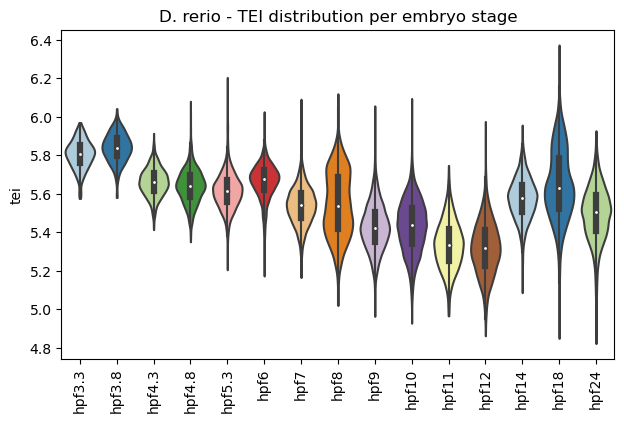

In [25]:
plt.rcParams['figure.figsize'] = [6.5, 4.5]
ax = sc.pl.violin(adata=zebrafish_data,
                  keys=['tei'],
                  groupby='stage',
                  rotation=90,
                  palette='Paired',
                  stripplot=False,
                  inner='box',
                  show=False)
ax.set_title('D. rerio - TEI distribution per embryo stage')
plt.show()
plt.rcParams['figure.figsize'] = [4.4, 3.3]

### Boxplot gene age class per embryo stage and add significance

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Boxplot gene age class per embryo stage and per cell type

E.g. to just show the same plot for a selected cell-type, one could do the following.

1. List all annotated cell types:

In [26]:
list(set(zebrafish_data.obs['cell_type']))

['neural anterior',
 'epiblast',
 'endoderm',
 'epidermal (gbx2+)',
 'forerunner cells',
 'hindbrain',
 'neural crest',
 'midbrain ventral',
 'dorsal margin involuted',
 'notochord',
 'periderm',
 'optic cup',
 'blood island',
 'xanthoblast',
 'epidermal (foxi3a+)',
 'hindbrain ventral',
 'blastomere',
 'retina pigmented epithelium',
 'roofplate',
 'pronephric duct',
 'epidermal',
 'olfactory placode',
 'myotome',
 'melanoblast',
 'mesoderm lateral plate (fli1a+)',
 'differentiating neurons (eomesa+)',
 'neural plate posterior',
 'mesoderm lateral plate',
 'otic placode',
 'lateral line primordium',
 'diencephalon (aplnr2+)',
 'mesoderm lateral plate (tbx1+)',
 'lens placode',
 'mesoderm adaxial cells',
 'DEL',
 'germline',
 'floorplate',
 'neural plate anterior',
 'tailbud mesoderm',
 'macrophage',
 'margin',
 'prechordal plate',
 'gut',
 'ionocyte',
 'apoptotic like',
 'midbrain',
 'differentiating neurons (dlx1a+)',
 'pectoral fin field',
 'hindbrain dorsal',
 'optic primordium',
 '

2. Loop over all cell types:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

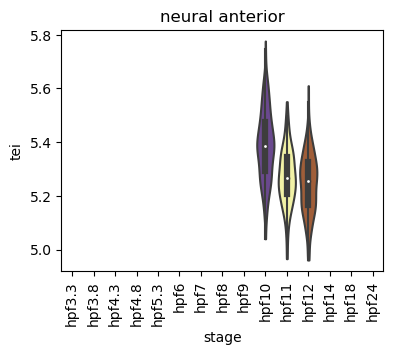

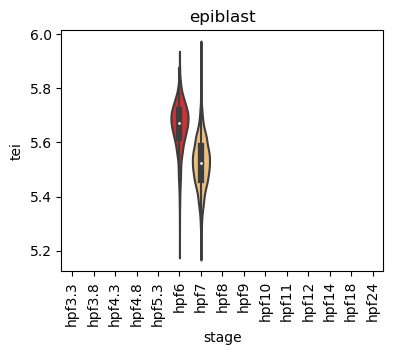

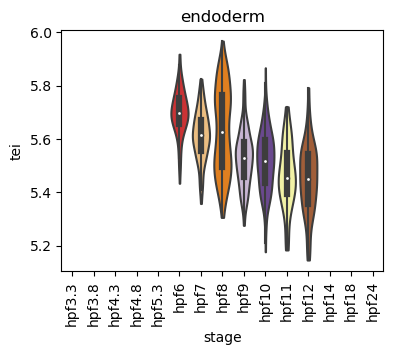

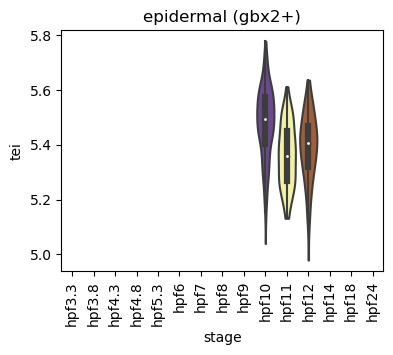

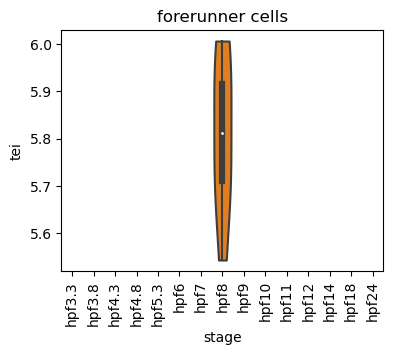

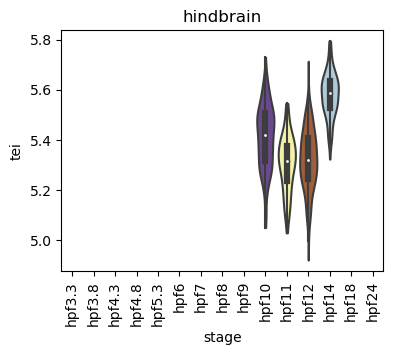

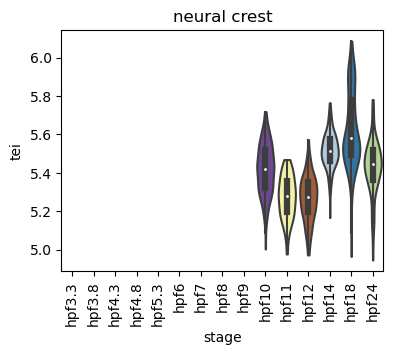

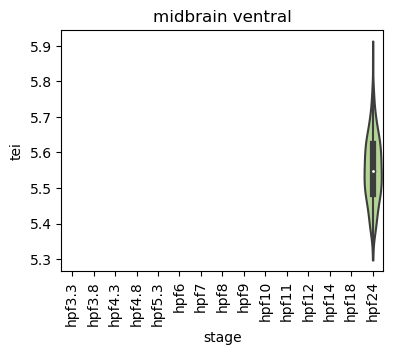

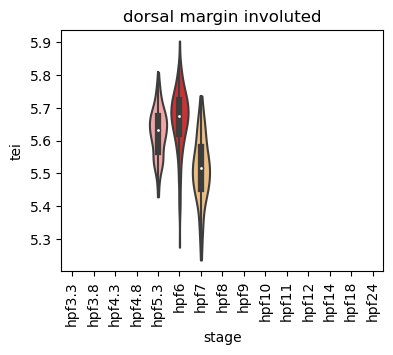

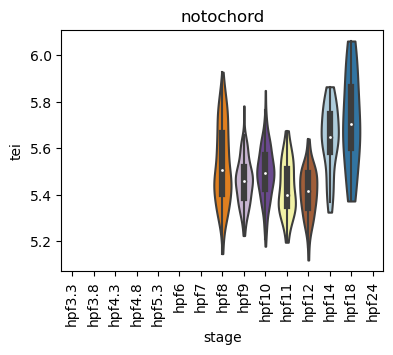

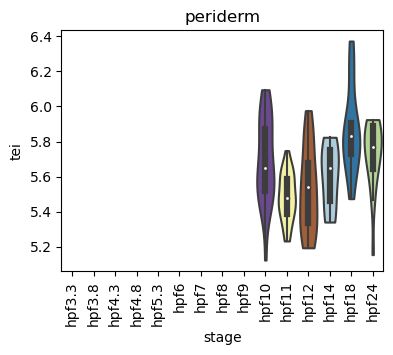

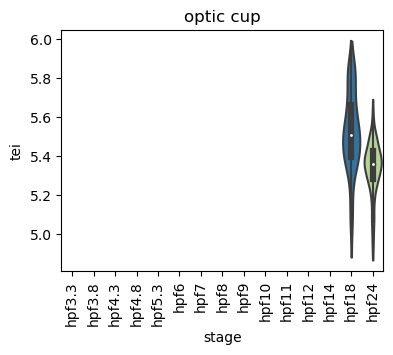

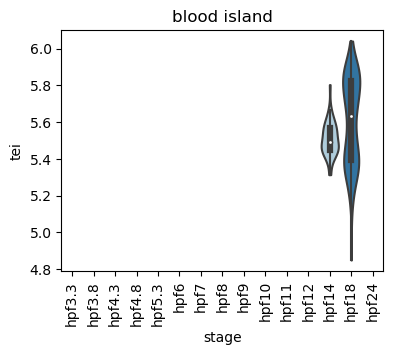

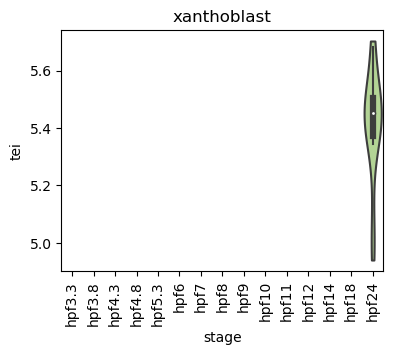

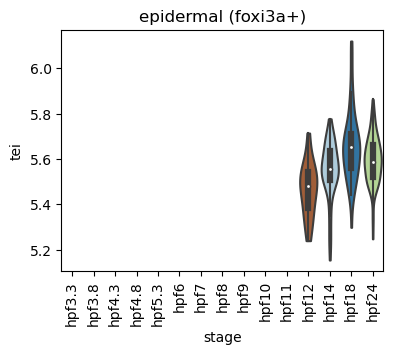

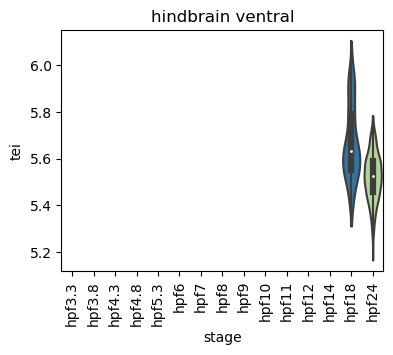

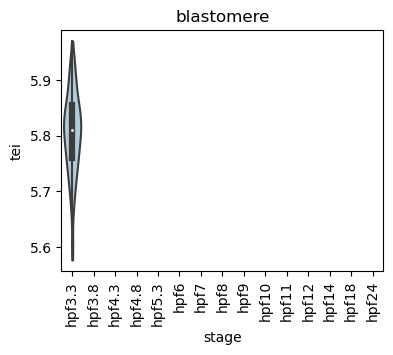

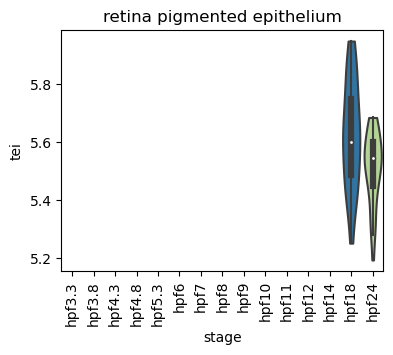

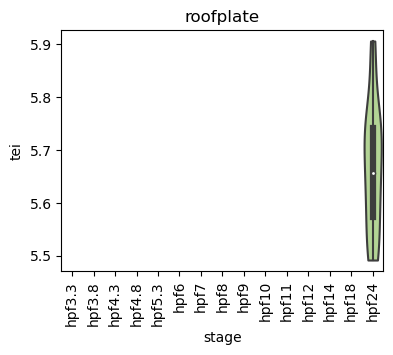

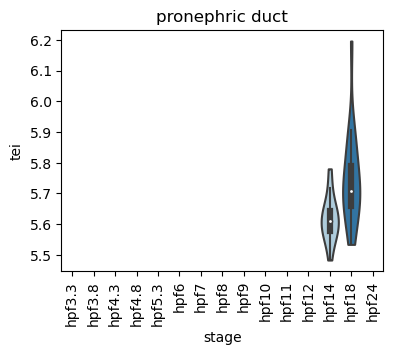

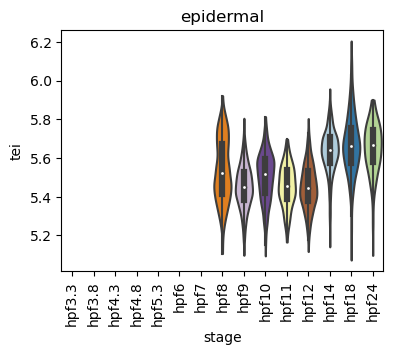

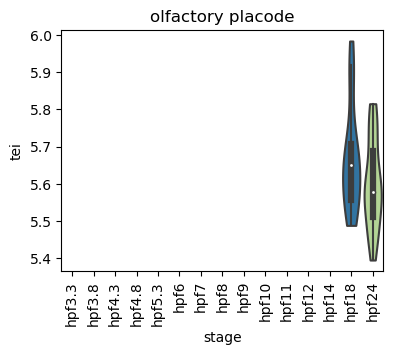

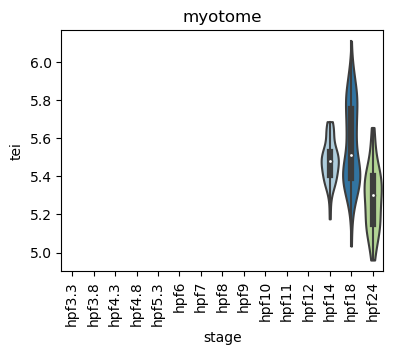

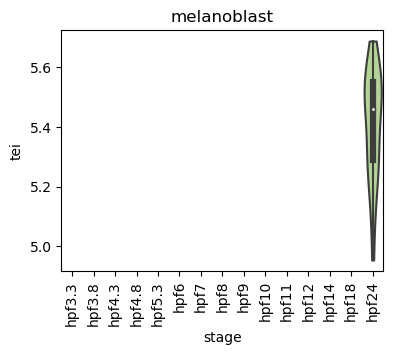

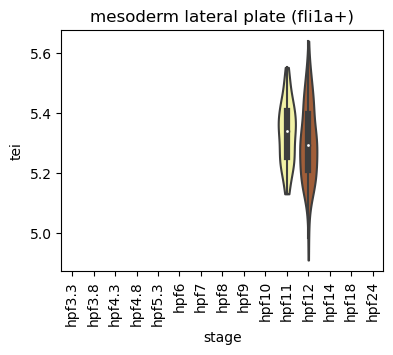

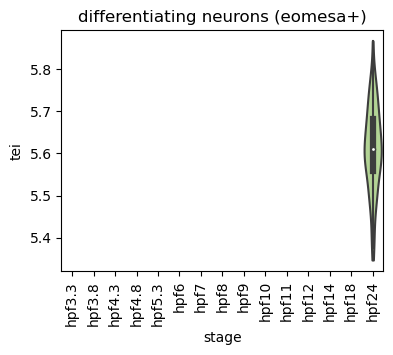

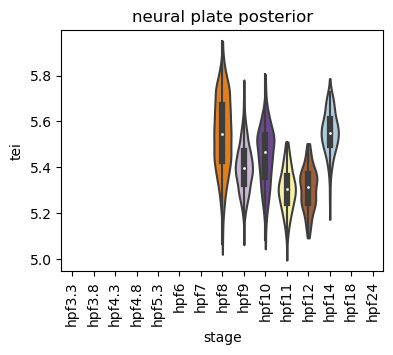

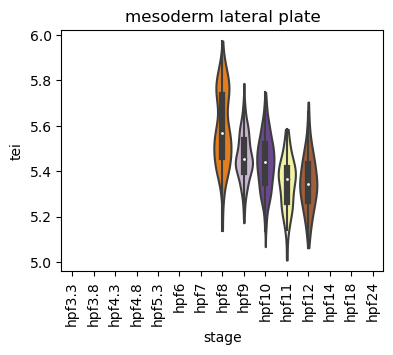

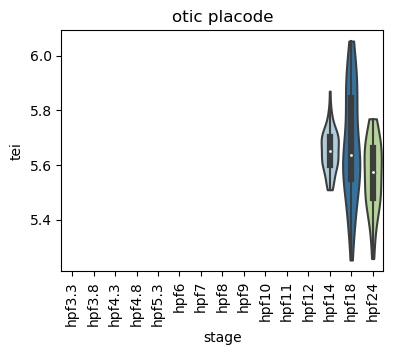

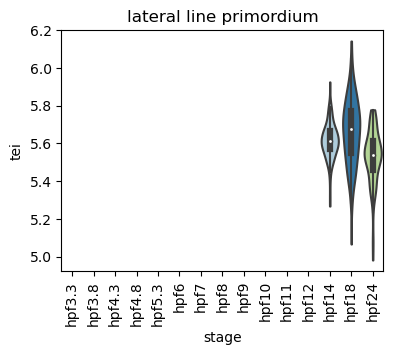

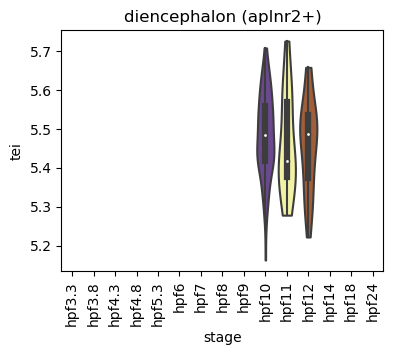

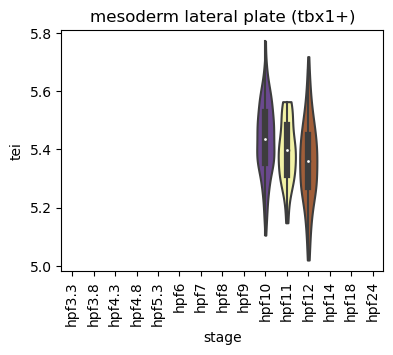

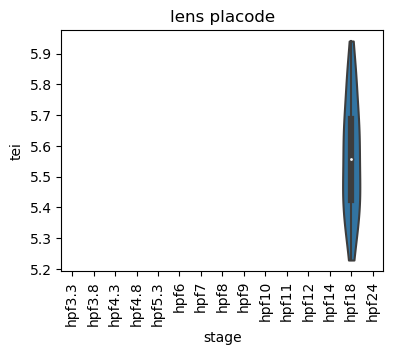

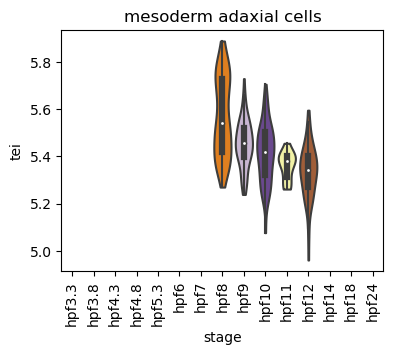

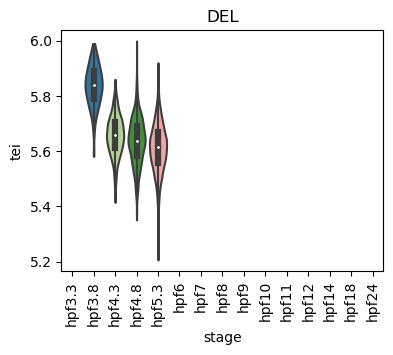

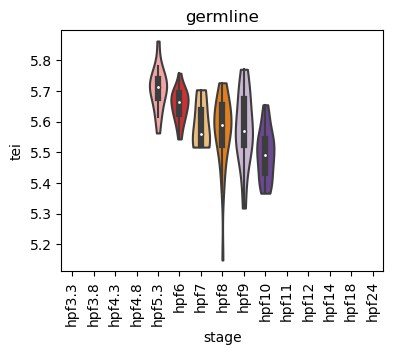

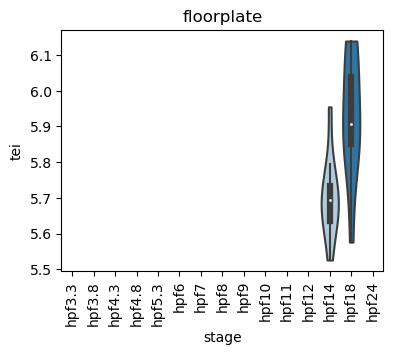

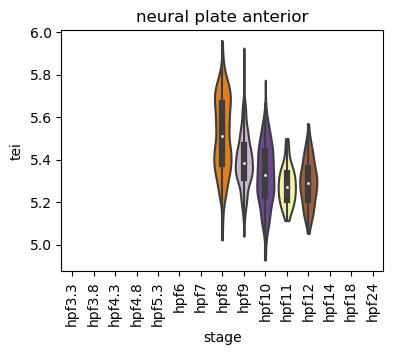

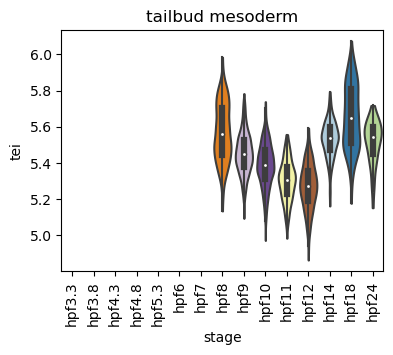

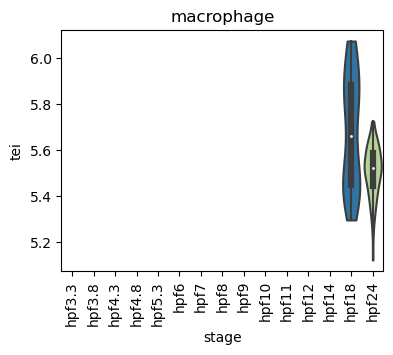

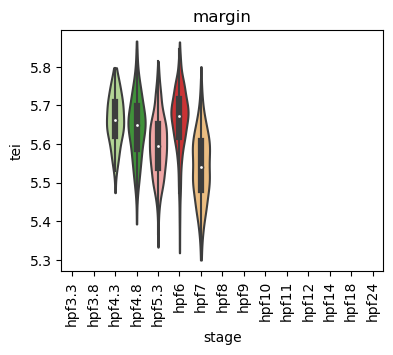

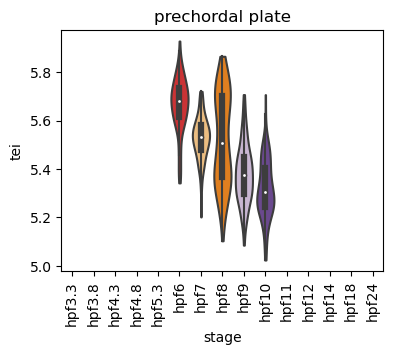

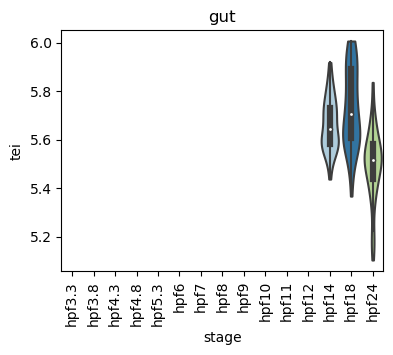

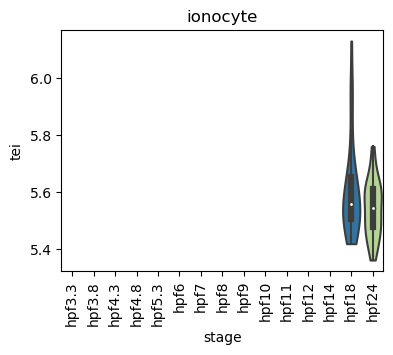

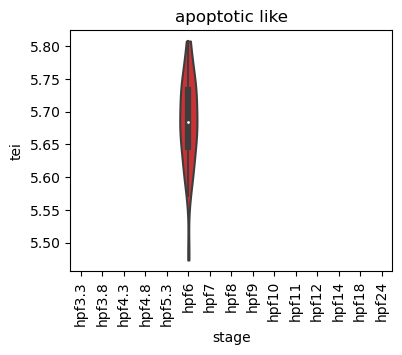

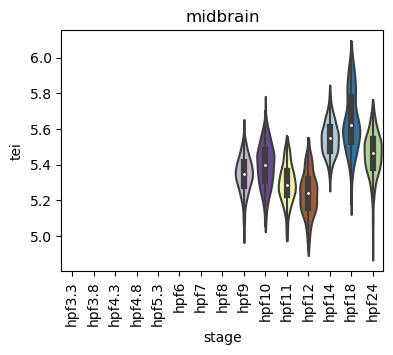

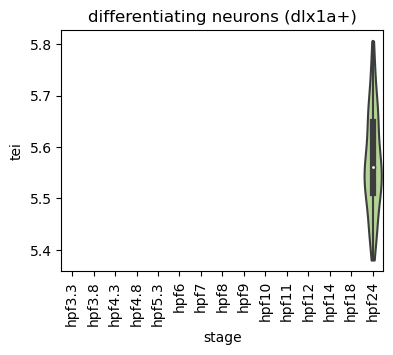

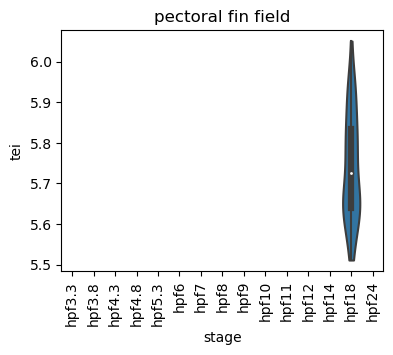

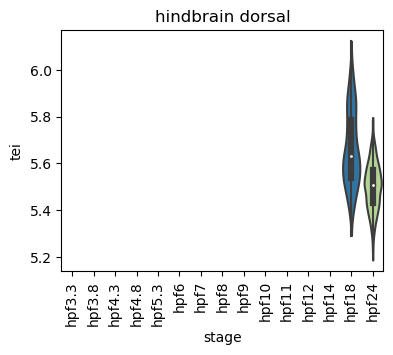

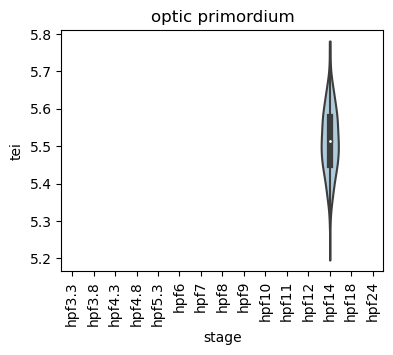

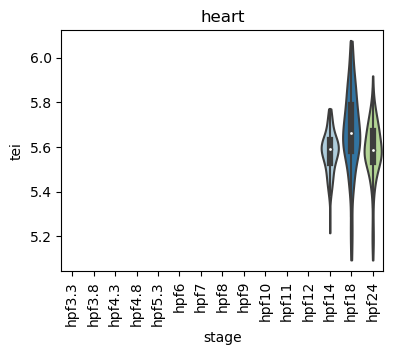

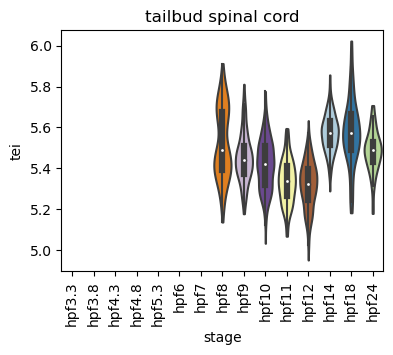

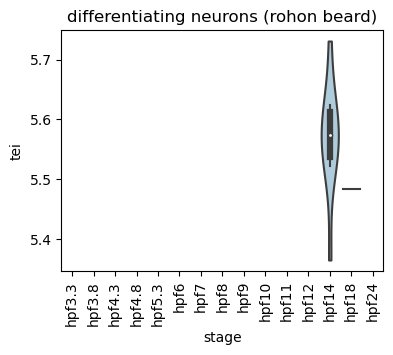

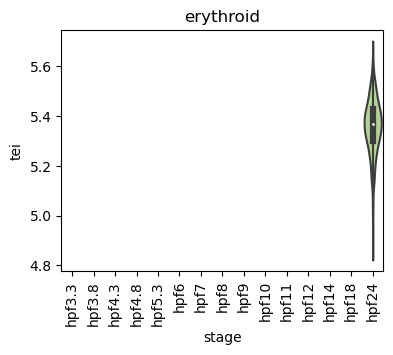

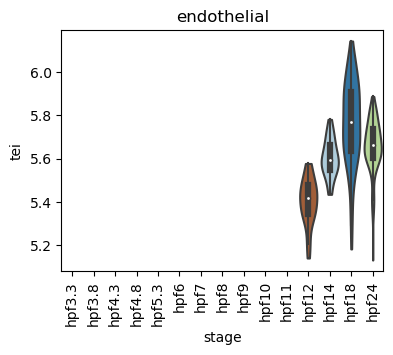

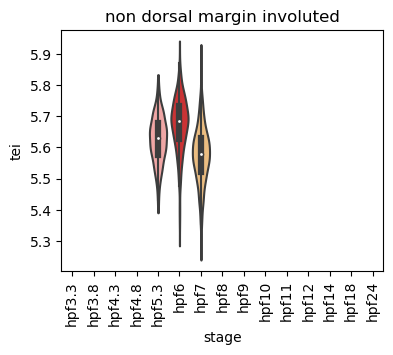

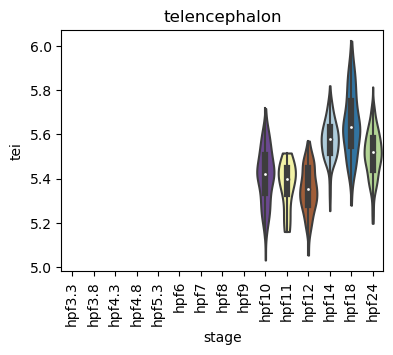

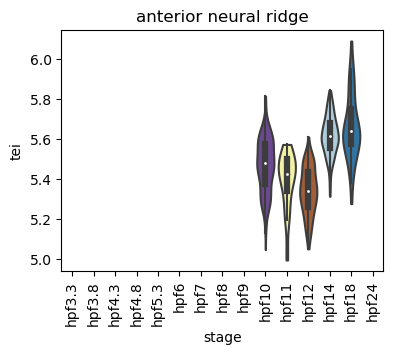

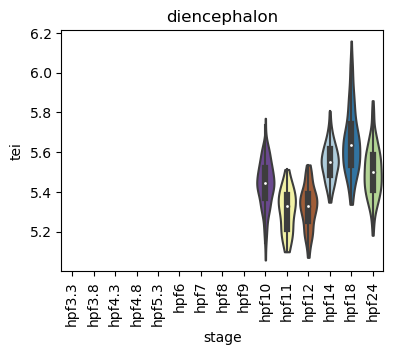

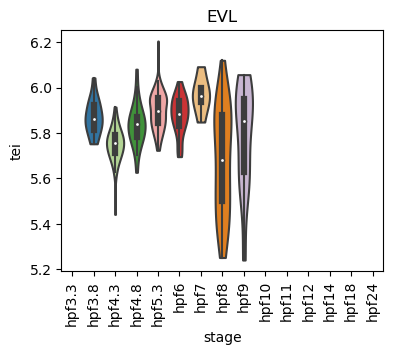

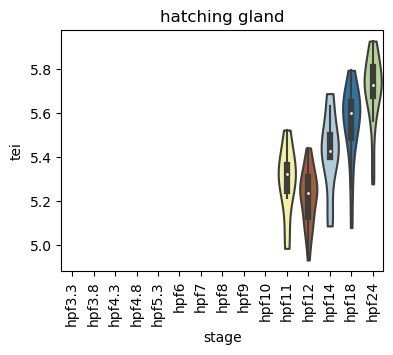

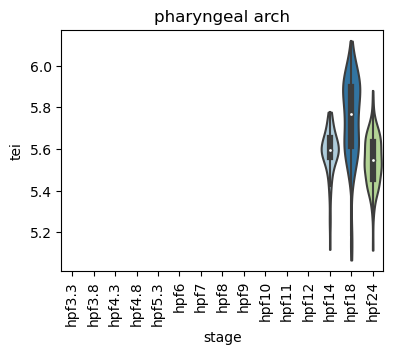

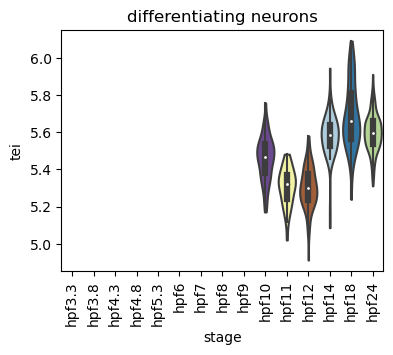

In [27]:
for ct in list(set(zebrafish_data.obs['cell_type'])):
    ax = sc.pl.violin(adata=zebrafish_data[zebrafish_data.obs['cell_type']==ct],
                      keys=['tei'],
                      groupby='stage',
                      rotation=90,
                      palette='Paired',
                      stripplot=False,
                      inner='box',
                      order=list(zebrafish_data.obs['stage'].cat.categories),
                      show=False)
    ax.set_title(ct)
    ax.set_xlabel('stage')
    plt.show()

### Plot relative expression per gene age class per sample stage

In [28]:
zebrafish_data_rematrix_grouped = orthomap2tei.get_rematrix(
    adata=zebrafish_data,
    gene_id=query_orthomap['geneID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    use='counts',
    var_type='mean',
    group_by_obs='stage',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=0,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)
zebrafish_data_rematrix_grouped

stage    hpf3.3    hpf3.8    hpf4.3    hpf4.8    hpf5.3      hpf6      hpf7  \
ps                                                                            
3      1.000000  0.763787  0.466752  0.284268  0.483931  0.481564  0.384060   
6      1.000000  0.809081  0.437535  0.269733  0.388836  0.503856  0.297106   
8      1.000000  0.824060  0.414671  0.254490  0.355464  0.470074  0.260572   
10     1.000000  0.831077  0.411780  0.261339  0.357994  0.476349  0.260767   
11     1.000000  0.865600  0.378906  0.272923  0.352424  0.471416  0.255806   
13     1.000000  0.879969  0.452083  0.314456  0.410616  0.532115  0.287119   
14     1.000000  0.899687  0.449817  0.328953  0.400997  0.633085  0.233571   
16     1.000000  0.867723  0.548742  0.564756  0.774593  0.670847  0.604867   
18     1.000000  0.869782  0.452952  0.341595  0.478496  0.249529  0.369100   
19     1.000000  0.992605  0.858099  0.824152  0.884298  0.355240  0.668145   
20     1.000000  0.735228  0.958915  0.727300  0.850712  0.292708  0.749759   
22     1.000000  0.785783  0.241326  0.218616  0.325823  0.594873  0.328793   
25     1.000000  0.998153  0.572311  0.474392  0.540644  0.265468  0.346071   
29     0.925673  1.000000  0.660387  0.587410  0.709576  0.933434  0.548793   

stage      hpf8      hpf9     hpf10     hpf11     hpf12     hpf14     hpf18  \
ps                                                                            
3      0.324288  0.200180  0.263576  0.000000  0.008070  0.464345  0.564625   
6      0.313188  0.155969  0.241321  0.000000  0.003263  0.499420  0.636556   
8      0.288058  0.123445  0.193471  0.000000  0.003817  0.458995  0.653966   
10     0.288836  0.127462  0.208406  0.000000  0.005533  0.490026  0.667754   
11     0.295930  0.109932  0.183937  0.000000  0.006799  0.412106  0.616927   
13     0.334316  0.129218  0.223298  0.000000  0.001074  0.544824  0.667480   
14     0.321922  0.123774  0.193121  0.000000  0.000249  0.525102  0.875673   
16     0.476988  0.311682  0.261083  0.048721  0.000000  0.430039  0.634124   
18     0.208163  0.168413  0.066178  0.026141  0.000000  0.094423  0.185906   
19     0.444361  0.441715  0.234261  0.172212  0.132878  0.091709  0.200682   
20     0.473234  0.571193  0.319447  0.385633  0.362103  0.009518  0.087335   
22     0.346191  0.088635  0.202888  0.000000  0.020581  0.356134  0.392432   
25     0.225424  0.259061  0.147149  0.144565  0.127149  0.048807  0.176999   
29     0.472150  0.218427  0.263950  0.007757  0.000000  0.364540  0.347877   

stage     hpf24  
ps               
3      0.349337  
6      0.371327  
8      0.335948  
10     0.351927  
11     0.344885  
13     0.312890  
14     0.394390  
16     0.286768  
18     0.080072  
19     0.000000  
20     0.000000  
22     0.033779  
25     0.000000  
29     0.170495

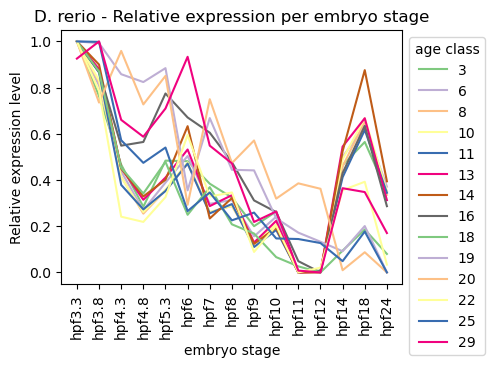

In [29]:
ax = sns.lineplot(zebrafish_data_rematrix_grouped.transpose(), palette='Accent', dashes=False)
ax.legend(fontsize=5, title='age class')
ax.set_title('D. rerio - Relative expression per embryo stage')
ax.set_xlabel('embryo stage')
ax.set_ylabel('Relative expression level')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
#plt.tick_params(labelsize=3)
plt.xticks(rotation=90)
plt.show()

### Get partial TEI values to visualize gene age class contributions

Partial `TEI` values can give an idea about which gene age class contributed at most to the `global` `TEI` pattern.

In detail, each gene gets a `TEI` contribution profile as follows:

${TEI_{is} = f_{is} * ps_i}$

, where ${TEI_{is}}$ is the partial `TEI` value of gene ${i}$, ${f_{is} = e_{is} / \sum e_{is}}$ and ${ps_i}$ is the phylostratum of gene i.

${TEI_{is}}$ values are combined per ${ps}$.

The partial `TEI` values combined per strata give an overall impression of the contribution of each strata to the `global` `TEI` pattern.

One can either start from `counts` (`adata.X`) which is set as default or any other `layer` defined by the `layer` option (`layer=None`).

In addition, the `counts` can be `normalized` and `log-transformed` prior calculating partial `TEI` values (`normalize_total=False`, `log1p=False`, `target_sum=1e6`).

Further, these values can be combined per given observation, e.g. cell typer per sample timepoint (`group_by='cell_state'`).

The `get_pstrata` function of the `orthomap2tei` submodule will return two matrix, the first contains the sum of each partial `TEI` per gene age class and the second the corresponding frequencies.

Both can be further processed by returning the `cumsum` over the gene age classes. To get them set the option `cumsum=True`. The `cumsum` will result in either for the first matrix the `TEI` value per cell or mean `TEI` value per group, if one choose a observation with the `group_by` option. Or in case of the second frequency matrix will result in 1.

With the `standard_scale` option either gene age classes (`standard_scale=0` rows) or cells or groups (`standard_scale=1` columns) can be scaled, subtract the minimum and divide each by its maximum. By default no scaling is applied (`standard_scale=None`).

The resulting data will be visualized in the downstream section.

In [30]:
zebrafish_pstrata = orthomap2tei.get_pstrata(adata=zebrafish_data,
    gene_id=query_orthomap['geneID'],
    gene_age=query_orthomap['PSnum'],
    keep='min',
    layer=None,
    cumsum=False,
    group_by_obs='stage',
    obs_fillna='__NaN',
    obs_type='mean',
    standard_scale=None,
    normalize_total=True,
    log1p=True,
    target_sum=1e6)
zebrafish_pstrata[0]

stage    hpf3.3    hpf3.8    hpf4.3    hpf4.8    hpf5.3      hpf6      hpf7  \
ps                                                                            
3      1.113356  1.114005  1.229654  1.273117  1.278153  1.197770  1.313577   
6      2.637362  2.616733  2.497146  2.419261  2.424246  2.556530  2.393082   
8      0.517103  0.514600  0.454584  0.430204  0.432281  0.463723  0.415157   
10     0.678416  0.685693  0.622953  0.612870  0.600758  0.637421  0.585663   
11     0.247444  0.254401  0.206657  0.208631  0.203748  0.221855  0.194637   
13     0.135881  0.141672  0.131241  0.132061  0.128311  0.136144  0.122029   
14     0.033937  0.035818  0.030766  0.030896  0.029582  0.035797  0.025323   
16     0.046340  0.048377  0.051122  0.060191  0.061868  0.053915  0.060276   
18     0.100601  0.104195  0.091349  0.093186  0.096897  0.068719  0.093560   
19     0.094886  0.105762  0.129563  0.148972  0.135150  0.078638  0.123682   
20     0.020965  0.020492  0.029569  0.030210  0.028496  0.018420  0.029210   
22     0.032415  0.031151  0.021227  0.023941  0.024829  0.033635  0.027177   
25     0.078058  0.088461  0.086041  0.092972  0.085865  0.061021  0.077996   
29     0.068072  0.078519  0.079801  0.084859  0.085270  0.102441  0.076930   

stage      hpf8      hpf9     hpf10     hpf11     hpf12     hpf14     hpf18  \
ps                                                                            
3      1.281811  1.363028  1.330284  1.425889  1.429682  1.193865  1.152226   
6      2.444176  2.345638  2.406803  2.245628  2.243321  2.590851  2.618168   
8      0.429359  0.390495  0.402755  0.373524  0.373645  0.466532  0.502338   
10     0.604837  0.573526  0.589225  0.571378  0.572683  0.658186  0.684621   
11     0.204859  0.178078  0.185804  0.174756  0.176164  0.211250  0.230991   
13     0.128530  0.116387  0.121953  0.116905  0.115877  0.140308  0.138097   
14     0.028372  0.024326  0.025258  0.022640  0.022564  0.032801  0.039593   
16     0.054464  0.055294  0.048341  0.050639  0.046917  0.044654  0.046494   
18     0.076011  0.081326  0.064668  0.076974  0.071033  0.052164  0.054506   
19     0.101955  0.116639  0.087341  0.101105  0.094096  0.050310  0.052783   
20     0.025264  0.030754  0.024892  0.033129  0.032192  0.013354  0.013284   
22     0.027644  0.020457  0.023461  0.020015  0.021431  0.025511  0.022939   
25     0.069783  0.084367  0.071543  0.092356  0.089403  0.044680  0.047207   
29     0.068802  0.049840  0.049623  0.031444  0.030379  0.052481  0.044994   

stage     hpf24  
ps               
3      1.238431  
6      2.538900  
8      0.448213  
10     0.636619  
11     0.216543  
13     0.122644  
14     0.031172  
16     0.043846  
18     0.057179  
19     0.046790  
20     0.015106  
22     0.014938  
25     0.046444  
29     0.038655

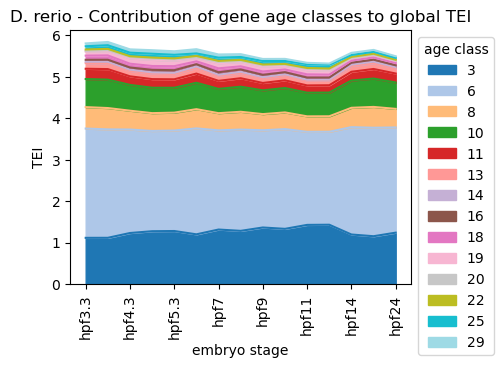

In [31]:
#plt.rcParams['figure.figsize'] = [9, 4.5]
ax=zebrafish_pstrata[0].transpose().plot.area(cmap='tab20')
ax.legend(fontsize=3, title='age class')
ax.set_title('D. rerio - Contribution of gene age classes to global TEI')
ax.set_xlabel('embryo stage')
ax.set_ylabel('TEI')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.show()
#plt.rcParams['figure.figsize'] = [6, 4.5]

### Gene age class contribution of one cell type

EVL:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

hatiching gland:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

endoderm:

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

__Note:__ Please change notebook cell from `raw` to `code` to see the plots.

### Color UMAP/TSNE by TEI

Follwoing the basic tutorial of the Scanpy python toolkit ([Wolf et al., 2018](https://doi.org/10.1186/s13059-017-1382-0)), one can highlight `TEI` values on a dimensional reduction of the scRNA dataset, like `PCA`, `UMAP` or `TSNE`.

#### Filtering

In [32]:
sc.pp.filter_genes(zebrafish_data, min_cells=3)
sc.pp.filter_cells(zebrafish_data, min_genes=200)

#### Normalization, Log transformation and Scaling

In [33]:
sc.pp.normalize_total(zebrafish_data, target_sum=1e6)
sc.pp.log1p(zebrafish_data)
sc.pp.scale(zebrafish_data, max_value=10)

#### PCA and Neighbor calculations

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


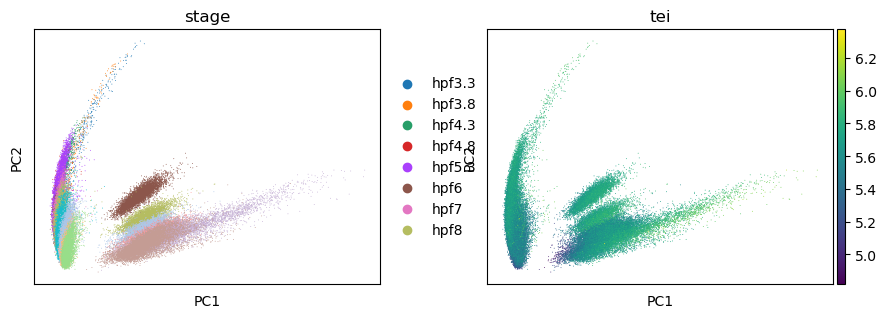

In [34]:
sc.tl.pca(zebrafish_data, svd_solver='arpack')
sc.pl.pca(zebrafish_data, color=['stage', 'tei'])

In [35]:
sc.pp.neighbors(zebrafish_data)

#### Embedding the neighborhood graph

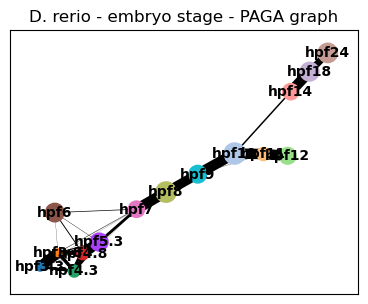

In [36]:
sc.tl.paga(zebrafish_data, groups='stage')
sc.pl.paga(zebrafish_data, title='D. rerio - embryo stage - PAGA graph')

#### UMAP

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


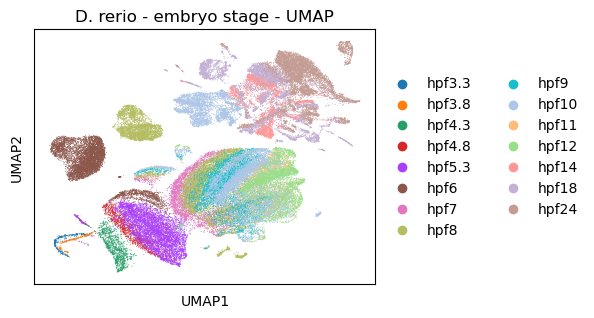

In [37]:
sc.tl.umap(zebrafish_data,
           init_pos='paga')
sc.pl.umap(zebrafish_data,
           title='D. rerio - embryo stage - UMAP', color=['stage'])

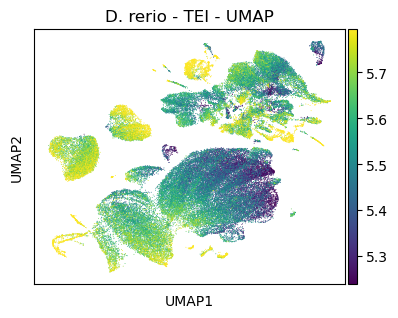

In [38]:
#plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(zebrafish_data,
           title='D. rerio - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95')
#plt.rcParams['figure.figsize'] = [6, 4.5]

corresponds to main Figure 1F

/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:325: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = ax.scatter(


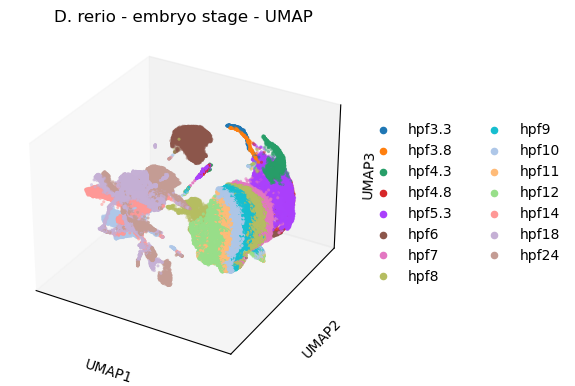

In [39]:
plt.rcParams['figure.figsize'] = [7.5, 4.5]
#3d
sc.tl.umap(zebrafish_data,
           n_components=3)
sc.pl.umap(zebrafish_data,
           title='D. rerio - embryo stage - UMAP', color=['stage'],
           projection='3d')
plt.rcParams['figure.figsize'] = [4.4, 3.3]

corresponds to main Figure 1G

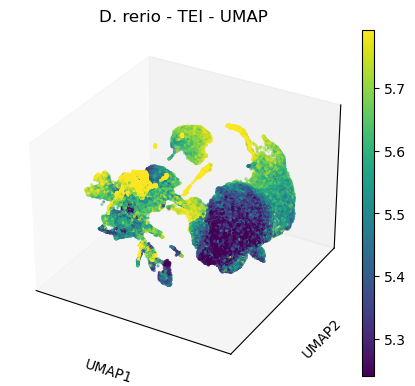

In [40]:
plt.rcParams['figure.figsize'] = [7.5, 4.5]
sc.pl.umap(zebrafish_data,
           title='D. rerio - TEI - UMAP',
           color=['tei'],
           color_map='viridis',
           vmin='p5',
           vmax='p95',
           projection='3d')
plt.rcParams['figure.figsize'] = [4.4, 3.3]

In [41]:
import plotly
import kaleido
import plotly.express as px
plotly.offline.init_notebook_mode(connected=False)

In [42]:
zebrafish_data

AnnData object with n_obs × n_vars = 71203 × 19761
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'group', 'cell_state', 'cell_type', 'tei', 'n_genes'
    var: 'features', 'genes', 'Phylostrata', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'stage_colors', 'neighbors', 'paga', 'stage_sizes', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [43]:
df = pd.DataFrame( {'UMAP1':zebrafish_data.obsm['X_umap'][:,0], 
                    'UMAP2':zebrafish_data.obsm['X_umap'][:,1],
                    'UMAP3':zebrafish_data.obsm['X_umap'][:,2],
                    'cell_type':zebrafish_data.obs['cell_type'].values.astype(str),
                    'cell_state':zebrafish_data.obs['cell_state'].values.astype(str),
                    'tei':zebrafish_data.obs['tei'].values,
                    'stage':zebrafish_data.obs['stage'].values,
                    'cell_id':zebrafish_data.obs.index.to_list()  } ) 
df.set_index('cell_id', inplace = True)
df.head()

UMAP1     UMAP2      UMAP3   cell_type  \
cell_id                                                                        
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC  8.001603  7.798748  13.366315  blastomere   
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT  8.396315  7.608164  11.704103  blastomere   
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC  8.022252  7.873591  12.900765  blastomere   
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN  7.795810  7.474202  14.216955  blastomere   
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT  7.463636  5.477603  16.006929  blastomere   

                                          cell_state       tei   stage  
cell_id                                                                 
hpf3.3_ZFHIGH_WT_DS5_AAAAGTTGCCTC  hpf3.3:blastomere  5.847391  hpf3.3  
hpf3.3_ZFHIGH_WT_DS5_AAACAAGTGTAT  hpf3.3:blastomere  5.794241  hpf3.3  
hpf3.3_ZFHIGH_WT_DS5_AAACACCTCGTC  hpf3.3:blastomere  5.783182  hpf3.3  
hpf3.3_ZFHIGH_WT_DS5_AAATGAGGTTTN  hpf3.3:blastomere  5.780480  hpf3.3  
hpf3.3_ZFHIGH_WT_DS5_AACCCTCTCGAT  hpf3.3:blastomere  5.915213  hpf3.3

In [44]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='stage')
fig.update_traces(marker_size = 2)
fig.write_html('zebrafish_scatter_3d_stage.html')

In [45]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='tei',
                    range_color=(5,5.5))
fig.update_traces(marker_size = 2)
fig.write_html('zebrafish_scatter_3d_tei.html')

In [46]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='cell_type')
fig.update_traces(marker_size = 2)
fig.write_html('zebrafish_scatter_3d_cell_type.html')

In [47]:
fig = px.scatter_3d(data_frame = df,
                    x='UMAP1', 
                    y='UMAP2', 
                    z='UMAP3',
                    color='cell_state')
fig.update_traces(marker_size = 2)
fig.write_html('zebrafish_scatter_3d_cell_state.html')

Please have a look at the documentation for other [case studies](https://orthomap.readthedocs.io/en/latest/tutorials/index.html#case-studies).